<a href="https://colab.research.google.com/github/janwaelty/Master-Thesis/blob/main/linear_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning for Artwork Valuation**

**This script provides the code for the hedonic linear model**

In [ ]:
import os
import shutil
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


drive.mount('/content/drive')
source_path = "/content/drive/My Drive/Colab Notebooks/numerical_model.ipynb"
destination_path = "/content/drive/My Drive/numerical_model.ipynb"

# Check if the source file exists before moving
if os.path.exists(source_path):
  # Move the file
  shutil.move(source_path, destination_path)
  print(f"Notebook moved to: {destination_path}")

!cp /content/drive/My\ Drive/data_preprocess.py /content/

from data_preprocess import (
    data_split as data_split,
    fit_visualization as fit_visualization,
    repeated_to_single_transactions as repeated_to_single_transactions,
    one_hot as one_hot,    data_filter as data_filter,
    get_location_dict as get_location_dict,
    add_location_column as add_location_column,
    load_image_data as load_image_data,
    check_image_existence as check_image_existence,
    filter_data_for_missing_images as filter_data_for_missing_images,
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def linear_model(X_train, X_test, y_train, y_test):
  # Create a linear regression model
  model = LinearRegression()
  model.fit(X_train, y_train)

  # Make predictions on the test set
  y_pred = model.predict(X_test)

  return model, y_pred


def ridge_model_grid_search(X_train, X_test, y_train, y_test, numerical_cols):

  # Create a column transformer to apply polynomial features only to numerical columns
  preprocessor = ColumnTransformer(
    transformers=[
        ('num', PolynomialFeatures(degree=3), numerical_cols),
        ('other', 'passthrough', [col for col in X_train.columns if col not in numerical_cols])
    ])

  # Create a pipeline to chain preprocessing steps with Ridge regression
  pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', Ridge())
  ])

  #  Define  parameter grid to search over the polynomial degree and alpha for Ridge
  param_grid = {
    'ridge__alpha': [0.0,0.1, 0.5, 1.0, 2.0],  # Regularization strength for Ridge regression
    'preprocessor__num__degree': [1, 2, 3]  # Degree of the polynomial features
  }

  # Perform grid search with 5-fold cross-validation
  grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

  # Fit the model
  grid_search.fit(X_train, y_train)

  # Get the best model and hyperparameters
  best_model = grid_search.best_estimator_
  print("Best Parameters:", grid_search.best_params_)

  #  Make predictions with the best model
  y_pred = best_model.predict(X_test)
  return y_pred, best_model

Dateien entpackt in: /content/data
number of nans: 1201
missing images: 86
Best Parameters: {'preprocessor__num__degree': 2, 'ridge__alpha': 2.0}
R-squared: 0.5222523334723703
Total R-squared: 0.522
Total MAPE: 6.94%
[Has prev] R²: 0.522, MAPE: 6.93%
[No prev]  R²: 0.418, MAPE: 7.24%
Plot saved to lin_reg.png


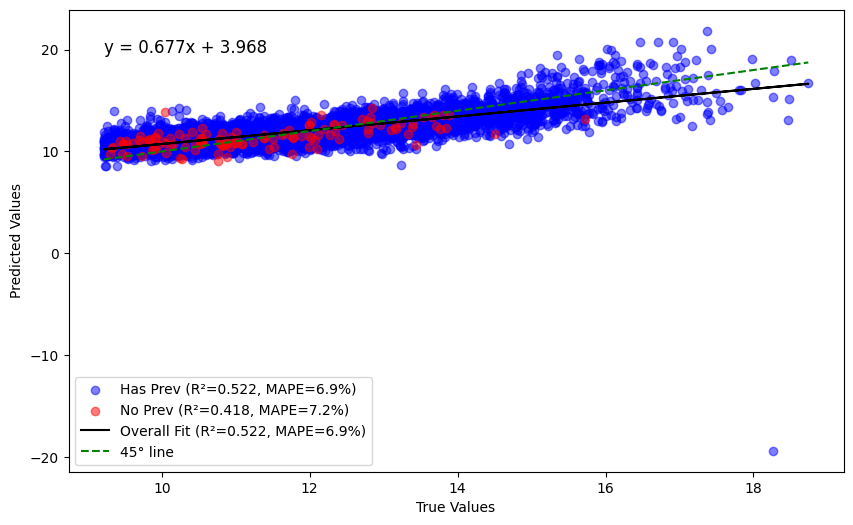

In [ ]:
if __name__ == '__main__':
  # load numerical data
  artist_data_path= "/content/drive/My Drive/artist_graph_data.xlsx"
  artwork_numeric_data = pd.read_excel(artist_data_path)

  # image loading
  zip_path = "/content/drive/My Drive/pic.zip"
  extract_path = "/content/data"
  load_image_data(zip_path, extract_path)

  # Check for missing images and remove them
  base_dir = "/content/data"
  image_paths = artwork_numeric_data['image_url'].values
  missing_images = check_image_existence(image_paths, base_dir)
  data_filtered = filter_data_for_missing_images(artwork_numeric_data, missing_images, base_dir)

  # variables to select from df
  selected_vars =  ['category', 'artist', 'transaction_price', 'height',
                  'width', 'medium', 'transaction_house',
                    'transaction_year','transaction_date',
                    'location', 'prev_transaction_price', 'has_prev_price', 'aspect_ratio']
  # categorical variables for one-hot encoding
  one_hot_vars = ['category', 'artist', 'medium', 'transaction_house', 'location']

  # variables that need min-max scaling
  numerical_cols = ['height', 'width', 'transaction_year', 'aspect_ratio', 'prev_transaction_price']

  # preprocessing and train/test split
  X_train, X_test, y_train, y_test = data_split(data_filtered,
                                                 selected_vars,
                                                one_hot_vars,
                                                numerical_cols,
                                               2022)

  y_pred, best_model = ridge_model_grid_search(X_train, X_test, y_train, y_test, numerical_cols)

  r2 = r2_score(y_test, y_pred)
  print(f"R-squared: {r2}")
  fit_visualization(X_test, y_test, y_pred, save_path="lin_reg.png")



